<a href="https://www.kaggle.com/code/sarath02003/face-recognition-using-vggface2?scriptVersionId=180399956" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import statements & Installing nessary modules

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
# /kaggle/input/recognizing-faces-in-the-wild

['celebrity-cropped-faces', 'celebrity-cropped-face', 'my_model_80']


In [20]:
from collections import defaultdict
from glob import glob
from random import choice, sample
from keras.preprocessing import image
import cv2
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam, Adagrad, RMSprop
from keras import regularizers


In [21]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-hyi2qj0f
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-hyi2qj0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-40_jqapy/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [22]:
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
import matplotlib.pyplot as plt
import warnings

# Data Augmentation

In [24]:
train_dir = '/kaggle/input/celebrity-cropped-faces/CroppedImages/train'

In [25]:
# Using ImageDataGenerator for data augmentation
generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.1
)

In [26]:
# Load and split the data into training and validation sets
train_ds = generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

Found 2089 images belonging to 31 classes.


In [27]:
len(train_ds)

17

In [28]:
import matplotlib.pyplot as plt
import os
import numpy as np

def display_images(dataset, class_names, num_images=25):
    """Display images from the dataset along with their labels."""
    plt.figure(figsize=(10, 10))
    data_batch, labels_batch = next(dataset)  # Get a batch of data and labels
    for i in range(min(num_images, len(data_batch))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(data_batch[i].astype("uint8"))  # No need for .numpy()
        class_index = np.argmax(labels_batch[i])  # Convert to numpy array
        plt.title(class_names[class_index])
        plt.axis("off")

In [29]:
class_names = sorted(os.listdir(train_dir))

## Displaying train_ds images

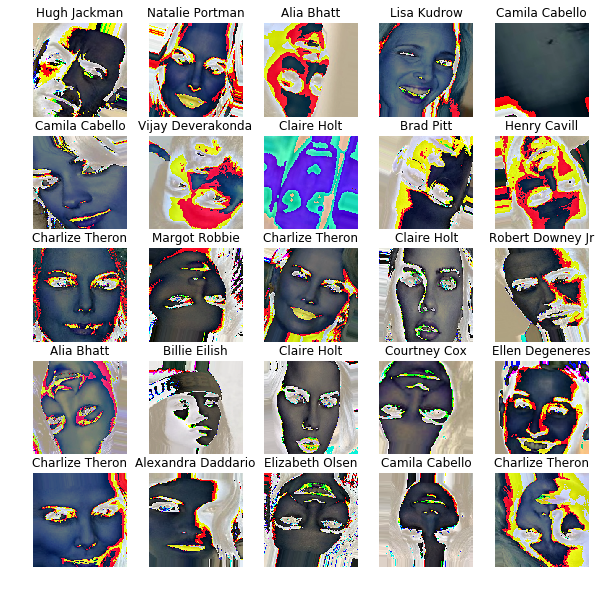

In [30]:
display_images(train_ds, class_names)
plt.show()

In [31]:
val_ds = generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)

Found 219 images belonging to 31 classes.


## Displaying val_ds images

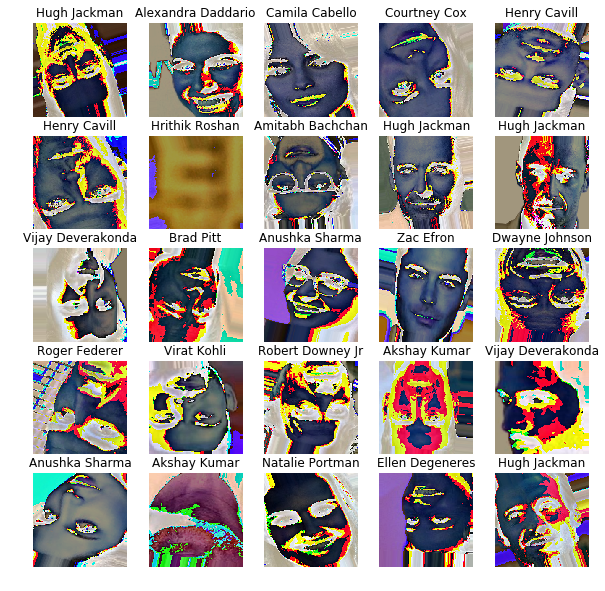

In [32]:
display_images(val_ds, class_names)
plt.show()

In [33]:
len(val_ds)

2

In [34]:
classes = list(train_ds.class_indices.keys())
print(classes)

['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']


# Transfer Learning with VGGFace

In [35]:
vggface_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [36]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras.layers import Input, Dense, Dropout 

# Define input tensor
input_tensor = Input(shape=(224, 224, 3))

# Load the VGGFace model without the top layers
vggface_model = VGGFace(include_top=False, input_tensor=input_tensor, pooling='avg')

# Freeze the layers of the VGGFace model
for layer in vggface_model.layers:
    layer.trainable = False

# Get the output of the last layer of VGGFace
x = vggface_model.output

# Add custom layers on top of the VGGFace model
# x = Dense(2048, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(2048, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(1024, activation="relu",kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
# x = Dense(512, activation="relu",kernel_regularizer=regularizers.l2(0.01))(x)
# x = Dropout(0.5)(x)
predictions = Dense(train_ds.num_classes, activation='softmax')(x)


58916864/58909280 [==============================] - 4s 0us/step


In [37]:
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create the final model
model = Model(inputs=[vggface_model.input], outputs=predictions)

# Compile the model with a different optimizer and learning rate scheduler
optimizer = Adam(lr=0.001)  # Use 'lr' instead of 'learning_rate'
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Define the learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# Display the model's architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

# Training the model

In [38]:
# Calculate steps per epoch for training and validation datasets
steps_per_epoch_train = train_ds.samples // train_ds.batch_size
steps_per_epoch_val = val_ds.samples // val_ds.batch_size

# Fit the model
history = model.fit_generator(
    train_ds,
    epochs=100,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=val_ds,
    validation_steps=steps_per_epoch_val,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/100
16/16 [==============================] - 43s 3s/step - loss: 12.5023 - acc: 0.1884 - val_loss: 8.2136 - val_acc: 0.5714
Epoch 2/100
16/16 [==============================] - 27s 2s/step - loss: 8.4113 - acc: 0.4243 - val_loss: 7.8725 - val_acc: 0.5469
Epoch 3/100
16/16 [==============================] - 28s 2s/step - loss: 7.5062 - acc: 0.5071 - val_loss: 6.9248 - val_acc: 0.6154
Epoch 4/100
16/16 [==============================] - 28s 2s/step - loss: 6.7800 - acc: 0.5688 - val_loss: 6.3131 - val_acc: 0.6094
Epoch 5/100
16/16 [==============================] - 29s 2s/step - loss: 6.1665 - acc: 0.6153 - val_loss: 5.7029 - val_acc: 0.6703
Epoch 6/100
16/16 [==============================] - 28s 2s/step - loss: 5.7084 - acc: 0.6226 - val_loss: 5.6155 - val_acc: 0.6250
Epoch 7/100
16/16 [==============================] - 28s 2s/step - loss: 5.1829 - acc: 0.6525 - val_loss: 4.7944 - val_acc: 0.7143
Epoch 8/100
16/16 [==============================] - 28s 2s/step - loss: 4.8839 - 

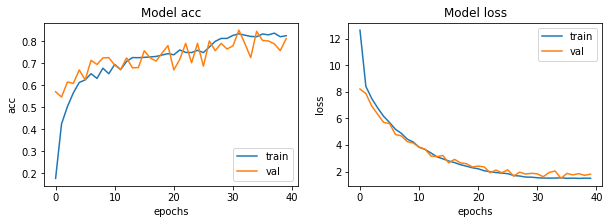

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Model Evaluation on  Train & Validation sets

In [47]:
# Calculate the number of steps per epoch for the train and validation datasets
train_steps = train_ds.samples // train_ds.batch_size
val_steps = val_ds.samples // val_ds.batch_size

# Evaluate the model on the train dataset
train_loss, train_accuracy = model.evaluate_generator(train_ds, steps=train_steps)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate_generator(val_ds, steps=val_steps)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Training Loss: 1.3617
Training Accuracy: 89.39%
Validation Loss: 1.6767
Validation Accuracy: 81.25%


# Data Augmentation & Evaluation on Test set

In [41]:
test_dir = '/kaggle/input/celebrity-cropped-faces/CroppedImages/test'
# Evaluate the model on the test set
test_ds = generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=8,
    shuffle=True  # Ensure no shuffling for evaluation
)

Found 218 images belonging to 31 classes.


In [42]:
len(test_dir)

56

In [48]:
# Calculate the number of steps for the test dataset
test_steps = test_ds.samples // test_ds.batch_size

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate_generator(test_ds, steps=test_steps)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 1.4079
Test Accuracy: 87.04%


# Save the model

In [44]:
# Save the model
model_save_path = '/kaggle/working/my_88_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/my_88_model.h5


# Using the one of the saved model

Found 218 images belonging to 31 classes.
Prediction accuracy for 35 random samples: 1.00


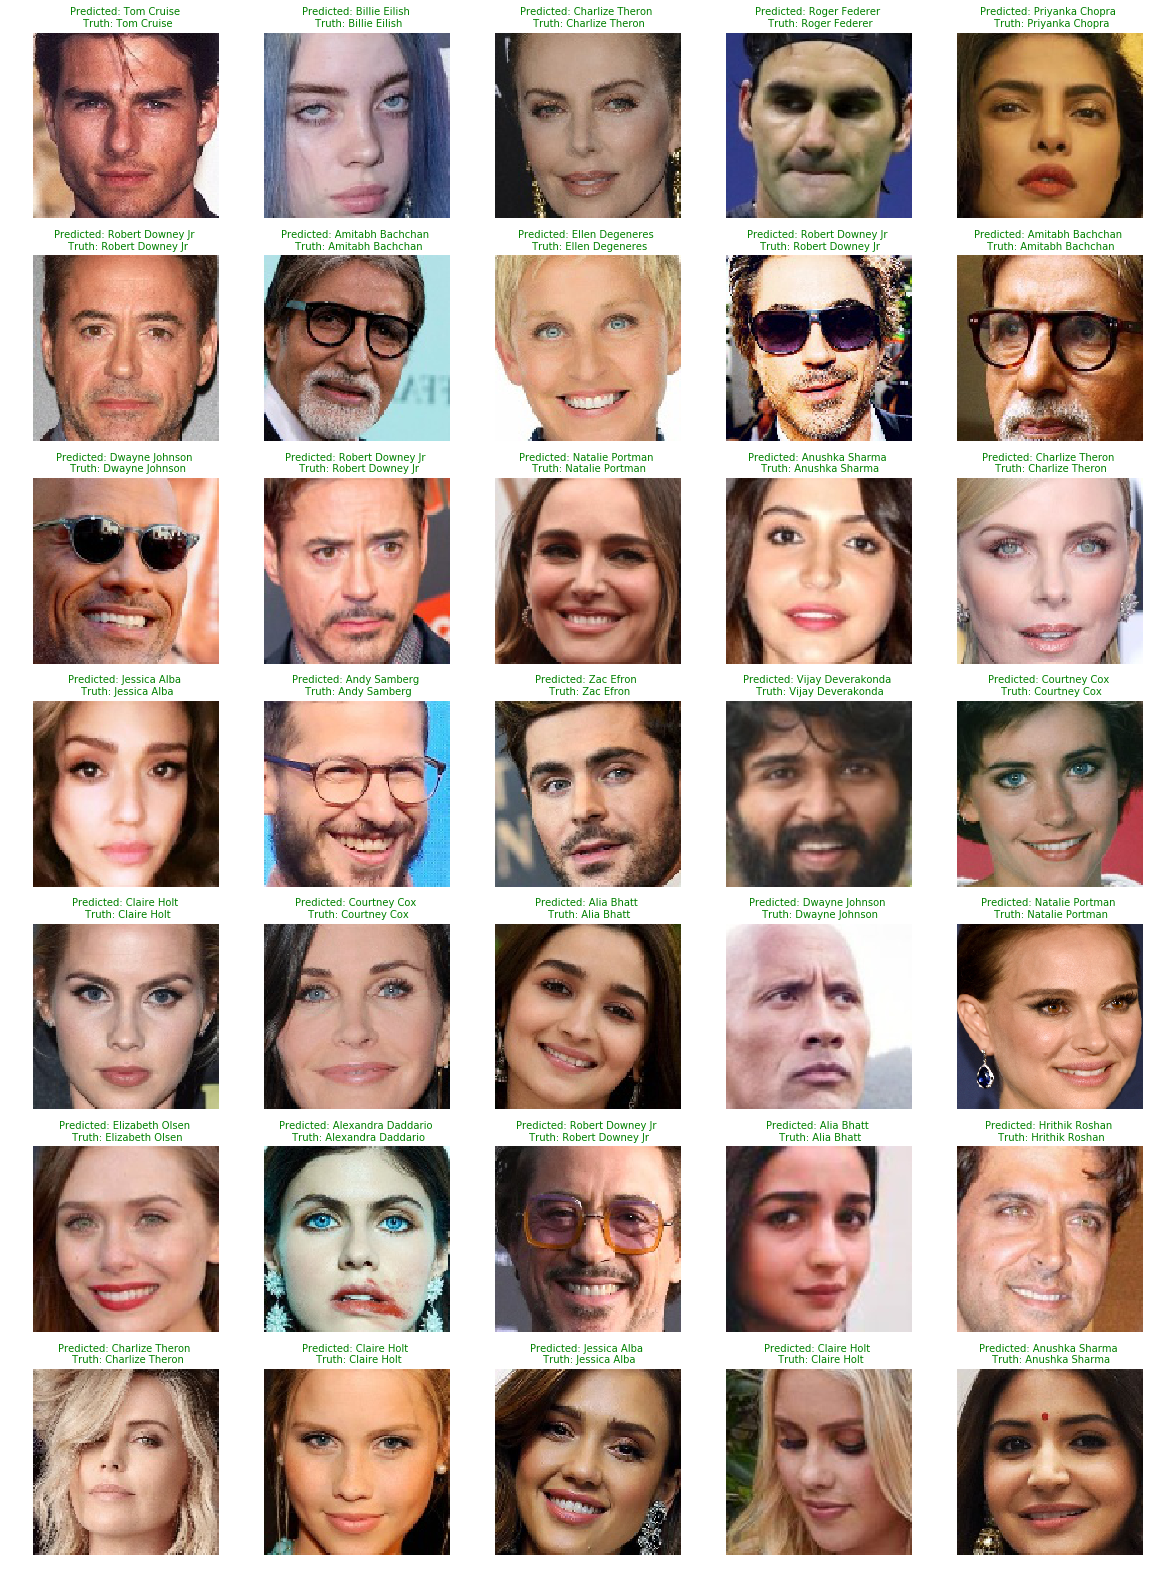

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

def load_original_images(directory, file_paths, target_size):
    """Loads original images from specified directory."""
    images = []
    for file_path in file_paths:
        img_path = os.path.join(directory, file_path)
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        images.append(img_array)
    return np.array(images)

def evaluate_model(dataset, model, class_names, original_images_dir, target_size, num_images=35):
    """Evaluates the model, displays predictions with original images, 
       and randomly selects a specified number of images."""
    
    # Ensure num_images doesn't exceed total images
    num_images = min(num_images, dataset.samples)
    
    data_all = []  # Store all data (across batches)
    labels_all = []  # Store all labels (across batches)
    file_paths_all = []  # Store all file paths (across batches)
    
    # Iterate through all batches and collect data, labels, and file paths
    for _ in range(dataset.n // dataset.batch_size):  
        data_batch, labels_batch = next(dataset)
        data_all.append(data_batch)
        labels_all.append(labels_batch)
        file_paths_all.extend(dataset.filenames)  # Collect all filenames
    
    data_all = np.concatenate(data_all)
    labels_all = np.concatenate(labels_all)
    
    # Randomly select the desired number of images
    random_indices = np.random.choice(len(data_all), size=num_images, replace=False)
    data_subset = data_all[random_indices]
    labels_subset = labels_all[random_indices]
    file_paths_subset = [file_paths_all[i] for i in random_indices]  # Collect file paths
    
    # Load the original images
    original_images = load_original_images(original_images_dir, file_paths_subset, target_size)
    
    # Get predictions from model
    predictions = model.predict(data_subset)
    
    num_rows = int(np.ceil(num_images / 5))  # Adjust rows for visualization
    num_cols = 5
    
    plt.figure(figsize=(20, num_rows * 4))  # Adjust figure size based on rows and increase row gap
    num_matches = 0
    
    for idx in range(num_images):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(original_images[idx].astype("uint8"))
        
        pred_idx = np.argmax(predictions[idx])
        truth_idx = np.argmax(labels_subset[idx])
        
        title = f"Predicted: {class_names[pred_idx]} \n Truth: {class_names[truth_idx]}"
        title_obj = plt.title(title, fontdict={"fontsize": 10})  # Adjust font size
        
        if pred_idx == truth_idx:
            num_matches += 1
            plt.setp(title_obj, color="g")
        else:
            plt.setp(title_obj, color="r")
    
    acc = num_matches / num_images
    print(f"Prediction accuracy for {num_images} random samples: {acc:.2f}")

# Load your model
# reloaded_model = load_model('/kaggle/input/my_model_80/tensorflow2/first_model/1/my_model.h5')
reloaded_model = load_model("/kaggle/input/my_model_80/tensorflow2/version3/1/my_88_model.h5")

# Define the class names for your dataset
class_names = list(train_ds.class_indices.keys())

test_dir = '/kaggle/input/celebrity-cropped-faces/CroppedImages/test'
original_images_dir = '/kaggle/input/celebrity-cropped-faces/CroppedImages/test'

# Prepare your test dataset
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model with 35 randomly chosen images
evaluate_model(test_generator, reloaded_model, class_names, original_images_dir, target_size=(224, 224), num_images=35)
